In [1]:
%pip install -qU langgraph

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import os
os.environ["OPENAI_API_KEY"] = os.getenv("openai_key")

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [21]:
llm.invoke("what is AI")

AIMessage(content='Artificial Intelligence (AI) refers to the simulation of human-like intelligence in machines that are programmed to think and learn. It encompasses a variety of technologies and systems, enabling machines to perform tasks that typically require human intelligence, such as understanding natural language, recognizing patterns, solving problems, and making decisions.\n\nAI can be classified into two main categories:\n\n1. **Narrow AI (Weak AI)**: This type of AI is designed and trained for a specific task, such as virtual assistants (like Siri and Alexa), recommendation systems, or image recognition systems. Narrow AI systems operate within a limited context and do not possess general intelligence.\n\n2. **General AI (Strong AI)**: This refers to a hypothetical form of AI that possesses the ability to understand, learn, and apply intelligence across a wide range of tasks, much like a human. General AI remains largely theoretical and has not yet been achieved.\n\nAI tech

## Create a state graph

In [22]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Our graph can now handle two key tasks:

# Each node can receive the current State as input and output an update to the state.
# Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

## Add an llm node

In [23]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

## Add an entry point

In [24]:
graph_builder.add_edge(START, "chatbot")

In [25]:
# The graph can be compiled to create a callable function.
# This function will take a State as input and return an updated State.
graph = graph_builder.compile()

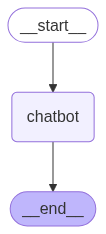

In [35]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Run the graph

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        
        break

Assistant: Hello! How can I assist you today?
Assistant: Artificial Intelligence (AI) is a branch of computer science that focuses on creating systems capable of performing tasks that typically require human intelligence. This includes a wide range of capabilities, such as:

1. **Learning**: The ability to learn from data and improve over time, often through techniques like machine learning.
2. **Reasoning**: The capacity to draw conclusions or make decisions based on available information.
3. **Problem Solving**: The ability to identify solutions for various challenges or tasks.
4. **Understanding Natural Language**: The capability to comprehend, interpret, and respond to human language in a meaningful way, often seen in applications like chatbots and virtual assistants.
5. **Perception**: The ability to analyze data from the senses, similar to how humans perceive the world through sight, sound, and touch. This includes computer vision and audio recognition.
6. **Autonomous Action**: 

## Add a tool to the Agent

In [21]:
%pip install -qU duckduckgo-search

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

# Initialize the DuckDuckGo search tool
duckduckgo_tool = DuckDuckGoSearchRun()
tools = [duckduckgo_tool]

In [ ]:
# test the search tool 
duckduckgo_tool.invoke("What's a 'node' in LangGraph?")

"Langraph: nodes, states, and edges. At the heart of LangGraph is the concept of a stateful graph:. State: Represents the context or memory that is maintained and updated as the computation ... In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ... LangGraph. Again considering the image blow, a snippet of LangGraph Python code is shown on the left, with the graph drawn out on the right. You can see in the code where the node is defined, builder.add_node with a ReturnNodeValue.For each node having an edge defined builder.add_edge.. You also see that a is set as the entry_point and d as the finish_point. LangGraph's core idea is using a graph for the application's workflow. This graph has two main par

In [18]:
from typing import Annotated


from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


tools = [duckduckgo_tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[duckduckgo_tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

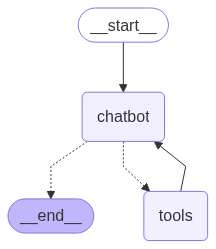

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Assistant: 
Assistant: On the evening of May 28, 2025, Elon Musk, the tech billionaire who has spearheaded the Trump administration's cost-cutting Department of Government Efficiency initiative since the start of U.S ... Billionaire Tesla CEO Elon Musk's time working for President Donald Trump is over. ... May 28, 2025, 10:37 PM EDT / ... a White House official told NBC News, a day after he criticized a Republican ... Lauren Irwin is a national politics reporter for the Deseret News. She covers national stories of impact from Washington, D.C. ... — Elon Musk (@elonmusk) May 29, 2025. Musk, the world's richest person, rose to political fame over the last year after spending at least $250 million on Trump's 2024 campaign. His influence grew after being ... Musk's 130 days allotted to work under the title of special government employee were expected to finish near the end of May. The earliest reported work from DOGE is dated Jan. 21, which wou

## For more exploration of langgraph, visit this page https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/#7-visualize-the-graph-optional

## Exemple 

In [3]:
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langgraph.graph import StateGraph,START, END

# Define graph
graph =  StateGraph(State)
def ask_user():
    pass
def search_database():
    pass
def generate_response():
    pass
# Entry point
graph.add_edge(START, "query_user")

# Define nodes (functions)
graph.add_node("query_user", ask_user)
graph.add_node("search_docs", search_database)
graph.add_node("respond", generate_response)

# Connect them
graph.add_edge("query_user", "search_docs")
graph.add_edge("search_docs", "respond")
graph.add_edge("respond", END)

# Compile and run
app = graph.compile()
#app.invoke({"input": "Find info about LangGraph"})


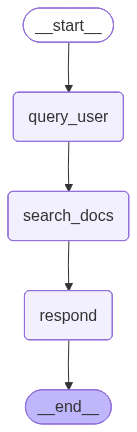

In [12]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass